In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## for distances
from scipy.spatial.distance import cosine

In [2]:
# Set pandas formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [3]:
# Set up wikidata API
!pip -q install qwikidata
!pip -q install sparqlwrapper

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
import seaborn as sns
import folium # mapping
from folium.plugins import HeatMap
import missingno as msno
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from typing import List, Dict

import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 8.6 MB/s eta 0:00:00
Setup Complete


In [4]:
# modified from https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
import json
import ast

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            print(result)
            break
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    # Function to remove invalid control characters
    def __remove_invalid_chars(text):
        return ''.join(char for char in text if ord(char) > 31 or char == '\n' or char == '\t')

    def _load(self) -> List[Dict]:
      """
      Helper function that loads the data from Wikidata using the SPARQLWrapper library,
      and transforms the results into a list of dictionaries.
      """
      results = self.sparql.queryAndConvert()['results']['bindings']
      return results  # Return directly as Python list


    def load_as_dataframe(self) -> pd.DataFrame:
      """
      Executes the SPARQL query and returns the results as a Pandas DataFrame.
      """
      results = self._load()
      df = pd.DataFrame(results)  # Convert to DataFrame directly

      # Ensure values are extracted properly
      df = df.applymap(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)

      return df


# Q1



## (a)

In [5]:
# Some relations such as wdt:P1081 links to multiple values,
# Fortunately, calling ?country wdt:P1081 ?HDI will automatically return the latest HDI,


countryQuery = """
SELECT DISTINCT
  ?countryLabel
  ?lifeExpectancy
  ?medianIncome
  ?HDI
  ?retirementAge
  ?unemploymentRate
WHERE {
  ?country wdt:P31 wd:Q6256. # Instance of a country
  ## YOUR CODE STARTS HERE
  #life expectancy
  OPTIONAL {?country wdt:P2250 ?lifeExpectancy.}
  #median income
  OPTIONAL {?country wdt:P3529 ?medianIncome.}
  #HDI
  OPTIONAL {?country wdt:P1081 ?HDI.}
  #retirement age
  OPTIONAL {?country wdt:P3001 ?retirementAge.}
  #unemplotyment rate
  OPTIONAL {?country wdt:P1198 ?unemploymentRate.}

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

## Output format is given below
Country_df = WikiDataQueryResults(countryQuery).load_as_dataframe()

##  YOUR CODE STARTS HERE
Country_df = Country_df.groupby('countryLabel').first().reset_index()
Country_df


,countryLabel,lifeExpectancy,HDI,unemploymentRate,retirementAge,medianIncome
0,Afghanistan,63.673,0.478,9,None,None
1,Albania,78.345,0.796,16,None,None
2,Algeria,76.078,0.745,10,60,None
3,Andorra,None,0.858,None,None,None
4,Angola,61.547,0.586,7,None,None
...,...,...,...,...,...,...
190,Venezuela,71,0.691,None,60,None
191,Vietnam,76.253,0.703,2,None,None
192,Yemen,64.953,0.455,60,None,None
193,Zambia,61.874,0.565,13,None,None


## (b)

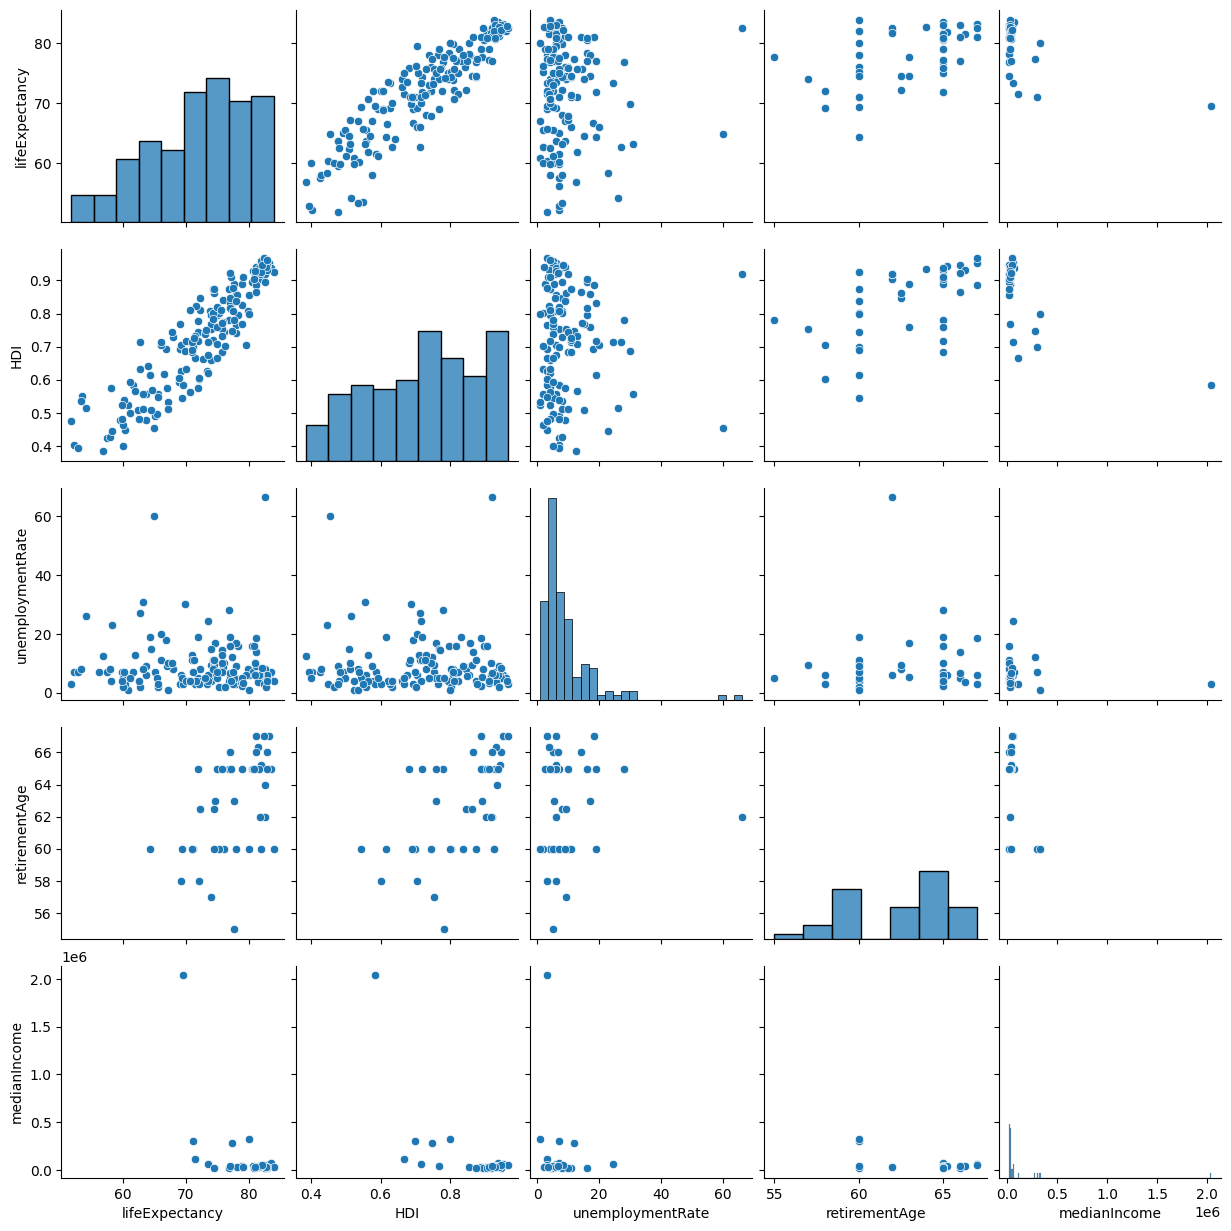

In [6]:
# get everything to numerical
Country_df=Country_df.drop(columns=['countryLabel'])
Country_df = Country_df.apply(pd.to_numeric)
## YOUR CODE STARTS HERE
sns.pairplot(Country_df)
plt.show()

## (c)

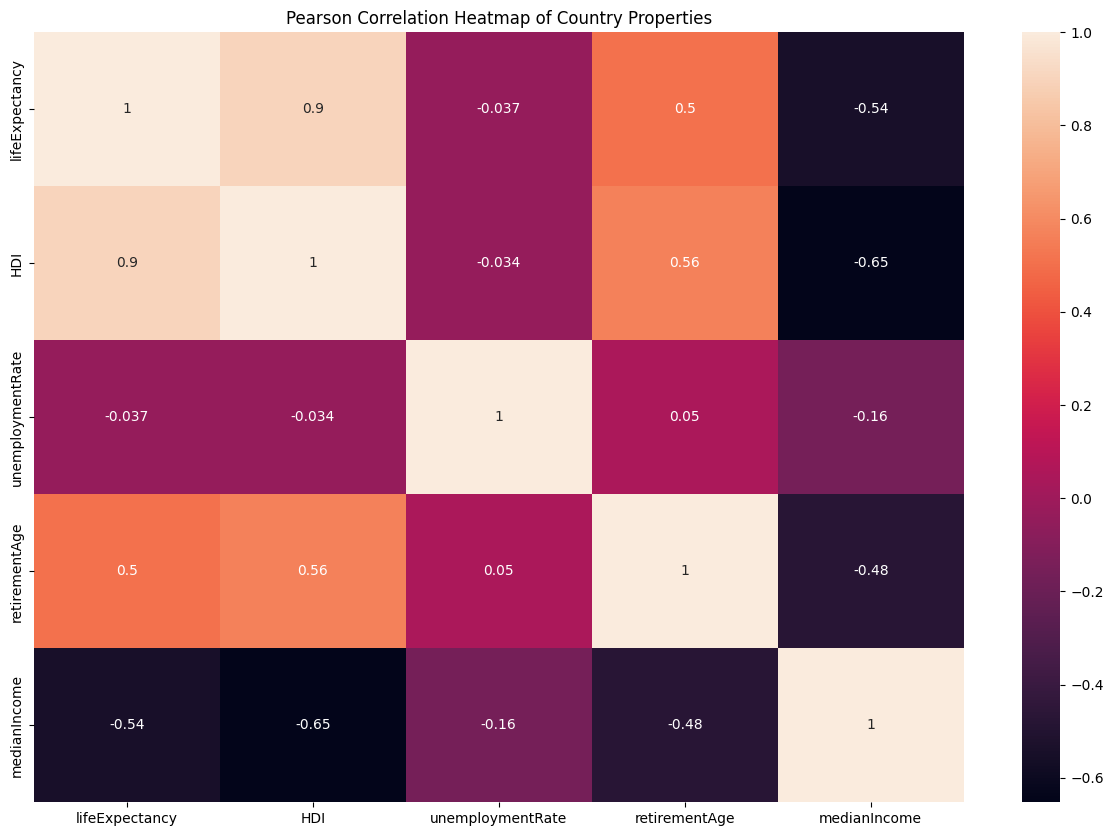

In [7]:
# Correlation Heatmap
corr = Country_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation Heatmap of Country Properties")
plt.show()

**Enter answer here:**
One noticable strong relationship is between life expectancy and HDI. Countries with higher HDI values tend to have longer life expectancies.

# Q2

## (a)

In [8]:
actor_genre_Query = """
SELECT distinct ?movieLabel ?actorLabel ?genreLabel ?releaseDate
WHERE {
  ## YOUR CODE STARTS HERE
  ?actor wdt:P166 wd:Q103916. #P166 is award winner and Q103916 is Academy Award for Best Actor
  ?movie wdt:P161 ?actor. #cast member is award winner
  ?movie wdt:P136 ?genre. #genre
  ?movie wdt:P577 ?releaseDate. #release date

  FILTER (?releaseDate > "1980-01-01T00:00:00Z"^^xsd:dateTime && ?releaseDate < "2020-01-01T00:00:00Z"^^xsd:dateTime)

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}

LIMIT 2000

"""

## Output format is given below
actor_genre_df = WikiDataQueryResults(actor_genre_Query).load_as_dataframe()
actor_genre_df

,releaseDate,movieLabel,actorLabel,genreLabel
0,1999-01-01T00:00:00Z,200 Cigarettes,Casey Affleck,comedy film
1,1999-01-01T00:00:00Z,200 Cigarettes,Casey Affleck,comedy drama
2,2010-12-16T00:00:00Z,Tron: Legacy,Cillian Murphy,cyberpunk
3,2010-12-17T00:00:00Z,Tron: Legacy,Cillian Murphy,cyberpunk
4,2011-01-27T00:00:00Z,Tron: Legacy,Cillian Murphy,cyberpunk
...,...,...,...,...
1995,1997-01-01T00:00:00Z,L.A. Confidential,Kevin Spacey,drama film
1996,2010-11-15T00:00:00Z,The Pillars of the Earth,Eddie Redmayne,drama television series
1997,1997-09-19T00:00:00Z,L.A. Confidential,Kevin Spacey,drama film
1998,1997-12-04T00:00:00Z,L.A. Confidential,Kevin Spacey,drama film


## (b)

genreLabel       American football film  Christmas film  LGBT-related film  Satanic film  Western film  action film  adventure film  animated film  anthology film  anti-war film  arthouse science fiction film  biographical film  black comedy film  boxing film  buddy cop film  buddy film  children's film  cinematic fairy tale  comedy  comedy drama  comedy film  comedy horror  comedy thriller  coming-of-age fiction  concert film  crime comedy film  crime drama film  crime film  crime thriller film  cyberpunk  detective film  disaster film  docudrama  documentary film  drama film  drama television series  dystopian film  epic film  family film  fantasy film  female buddy film  film based on a novel  film based on book  film based on literature  film noir  flashback film  gangster film  ghost film  girls with guns  heist film  historical drama  historical film  horror film  independent film  medieval film  melodrama  mockumentary  musical film  mystery film  neo-noir  ninja film  parody fi

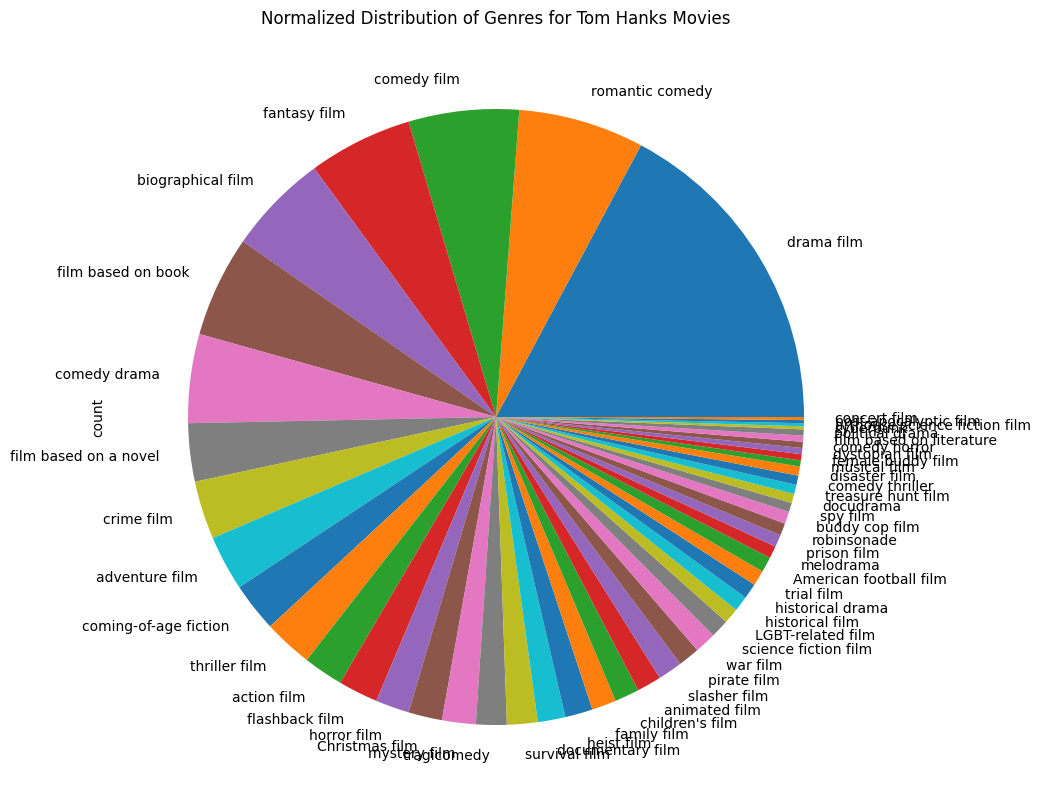

In [9]:
## YOUR CODE STARTS HERE
actor_genre_crosstab = pd.crosstab(actor_genre_df['actorLabel'], actor_genre_df['genreLabel'])
actor_genre_crosstab = actor_genre_crosstab.sort_index(axis=0).sort_index(axis=1)
print(actor_genre_crosstab)

# Filter the DataFrame for Tom Hanks movies
tom_hanks_df = actor_genre_df[actor_genre_df['actorLabel'] == 'Tom Hanks']

# Count each genre
genre_counts = tom_hanks_df['genreLabel'].value_counts()

# Normalize the counts
tom_hanks_normalized_genre_vector = genre_counts / genre_counts.sum()

# Create the pie chart
tom_hanks_normalized_genre_vector.plot(kind='pie', figsize=(15, 10))
plt.title('Normalized Distribution of Genres for Tom Hanks Movies')
plt.show()


## (c)

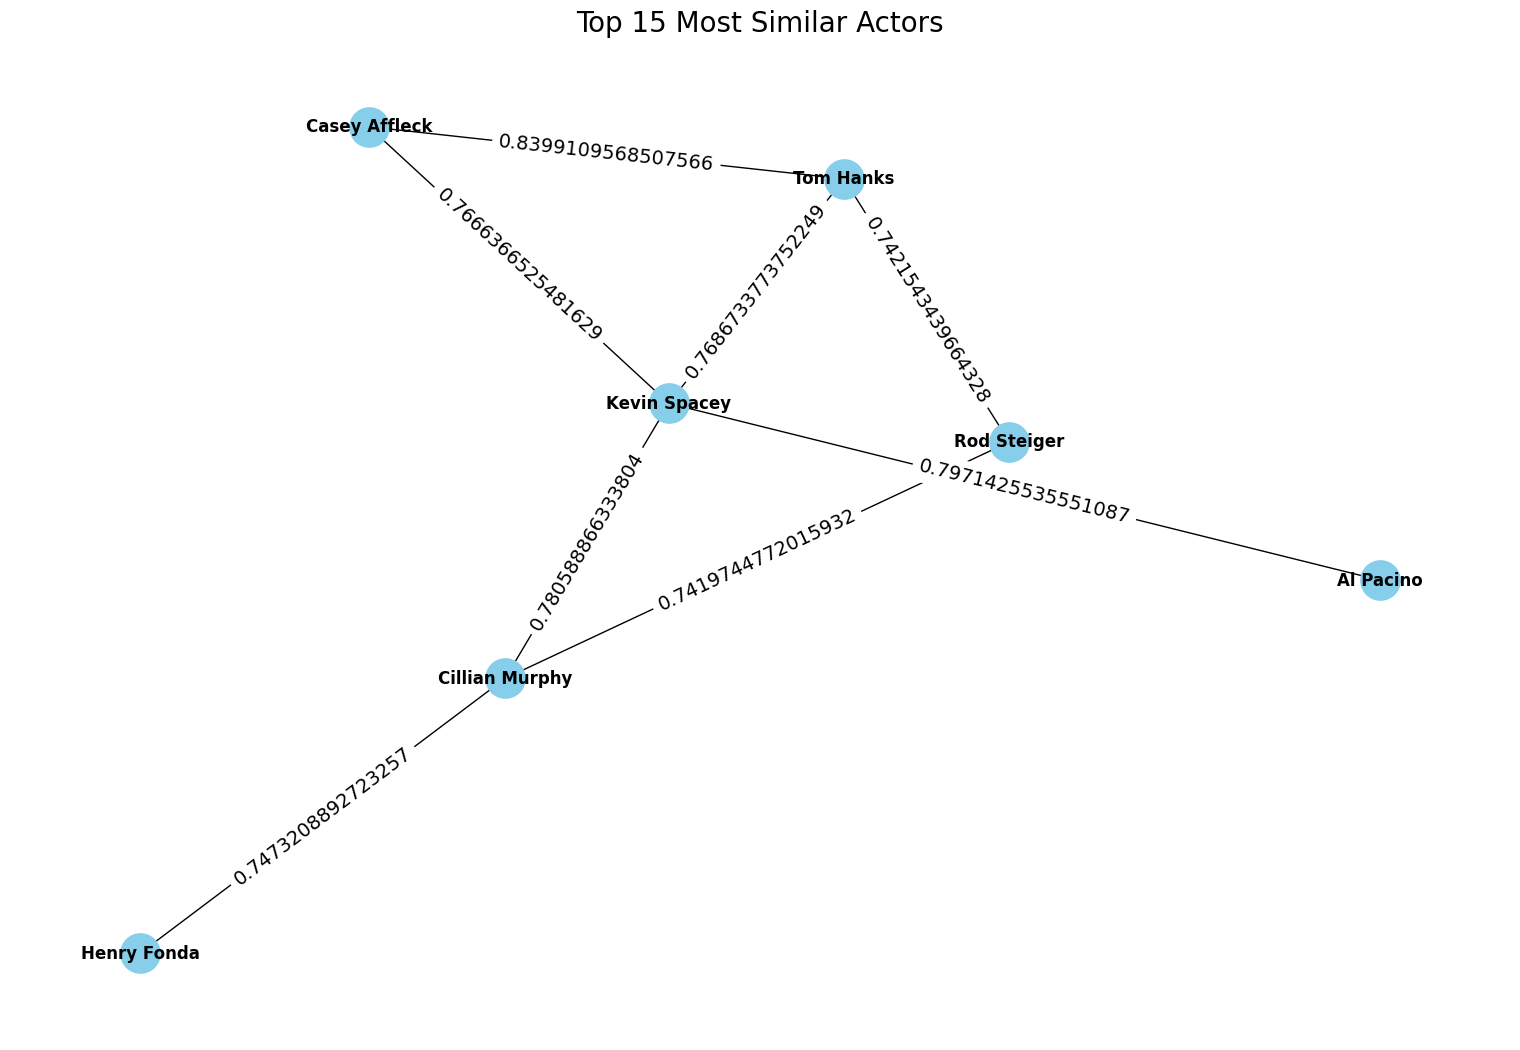

In [10]:
# Generate a graph of the similarity between the top 15 most similar actors.

# Initialize an empty list to store the results
similarity_results = []
## YOUR CODE STARTS HERE
for actor1 in actor_genre_crosstab.index:
    for actor2 in actor_genre_crosstab.index:
      if actor1 != actor2:
        vector1 = actor_genre_crosstab.loc[actor1].values
        vector2 = actor_genre_crosstab.loc[actor2].values
        similarity = 1 - cosine(vector1, vector2)
        similarity_results.append((actor1, actor2, similarity))
#sort by similarity and get the top 15 pairs
similarity_results.sort(key=lambda x: x[2], reverse=True)
top_15_pairs = similarity_results[:15]


G = nx.Graph()
# hint, similarity_results = [ (actors1, actors2, cosine_similarity_score), ... ]
# Each tuple will represent an edge

# YOUR CODE CONTINUES HERE
for actor1, actor2, similarity in top_15_pairs:
    G.add_edge(actor1, actor2, weight=similarity)

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", font_size=12, font_color="black", font_weight="bold")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14)
plt.title("Top 15 Most Similar Actors", fontsize=20)
plt.show()
